In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


In [ ]:
# 1. Load and preprocess the dataset
file_path = 'stacking.csv'
df = pd.read_csv(file_path)

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Split data into training (2021–2024) and testing (2025) sets
train_df = df[(df['Date'].dt.year >= 2021) & (df['Date'].dt.year <= 2024)]
test_df = df[df['Date'].dt.year == 2025]

# Define feature columns (base model predictions) and target column
feature_columns = ['KNN', 'LSTM','XG'] # choose the model
target_column = 'movement'

X_train = train_df[feature_columns]
y_train = train_df[target_column]
X_test = test_df[feature_columns]
y_test = test_df[target_column]

# 2. Evaluate accuracy of each base model
print("\nBase Models Accuracy:")
base_model_scores = {}
print(f"{'Model':<10} | {'Train Acc':<12} | {'Test Acc':<12}")
print("-"*40)
for col in feature_columns:
    # Convert predicted probabilities to binary labels
    train_pred = train_df[col].apply(lambda x: 1 if x >= 0.5 else 0)
    test_pred = test_df[col].apply(lambda x: 1 if x >= 0.5 else 0)
    
	# Compute accuracy on training and testing sets
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    base_model_scores[col] = test_acc
    print(f"{col:<10} | {train_acc:<12.4f} | {test_acc:<12.4f}")
print("-"*40)

# 3. Define hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.02, 0.005]
}

# 4. Create XGBoost classifier and apply GridSearchCV
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=0
)

# Perform 3-fold cross-validation grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',   
    cv=3,                
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Evaluate the best stacking model on test set
best_model = grid_search.best_estimator_

# extract predict class labels and probabilities
y_pred_stack = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute test accuracy
stacking_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Accuracy on Test Set: {stacking_acc:.4f}")

# Display feature importance of base models
importance_df = pd.DataFrame({
    'Model': feature_columns,
    'Weight': best_model.feature_importances_
}).sort_values(by='Weight', ascending=False)
print("\nFeature Importance:\n", importance_df)


# Store original predicted probability
output_df = test_df[['Date']].copy()
output_df['Probability'] = y_pred_proba
output_df['Probability'] = (y_pred_proba - np.min(y_pred_proba)) / (np.max(y_pred_proba) - np.min(y_pred_proba))
output_df['Actual'] = y_test.values

output_df.to_csv('stacking_pred_prob.csv', index=False)


Base Models Accuracy:
Model      | Train Acc    | Test Acc    
----------------------------------------
KNN        | 0.5572       | 0.6505      
LSTM       | 0.5736       | 0.6262      
XG         | 0.5005       | 0.5631      
----------------------------------------
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best CV Accuracy: 0.6179082419192499
Stacking Accuracy on Test Set: 0.6796

Feature Importance:
   Model    Weight
0   KNN  0.527925
1  LSTM  0.259847
2    XG  0.212228


Loading data...
Running Strategy...
【績效對決】
AI 策略總獲利   : $2,740,200 (最大持倉 10 口)
Buy & Hold 總獲利: $3,057,208 (固定持倉 3.92 口)
AI 策略平均持倉 : 3.92 口
結果: Buy & Hold 領先 $317,008


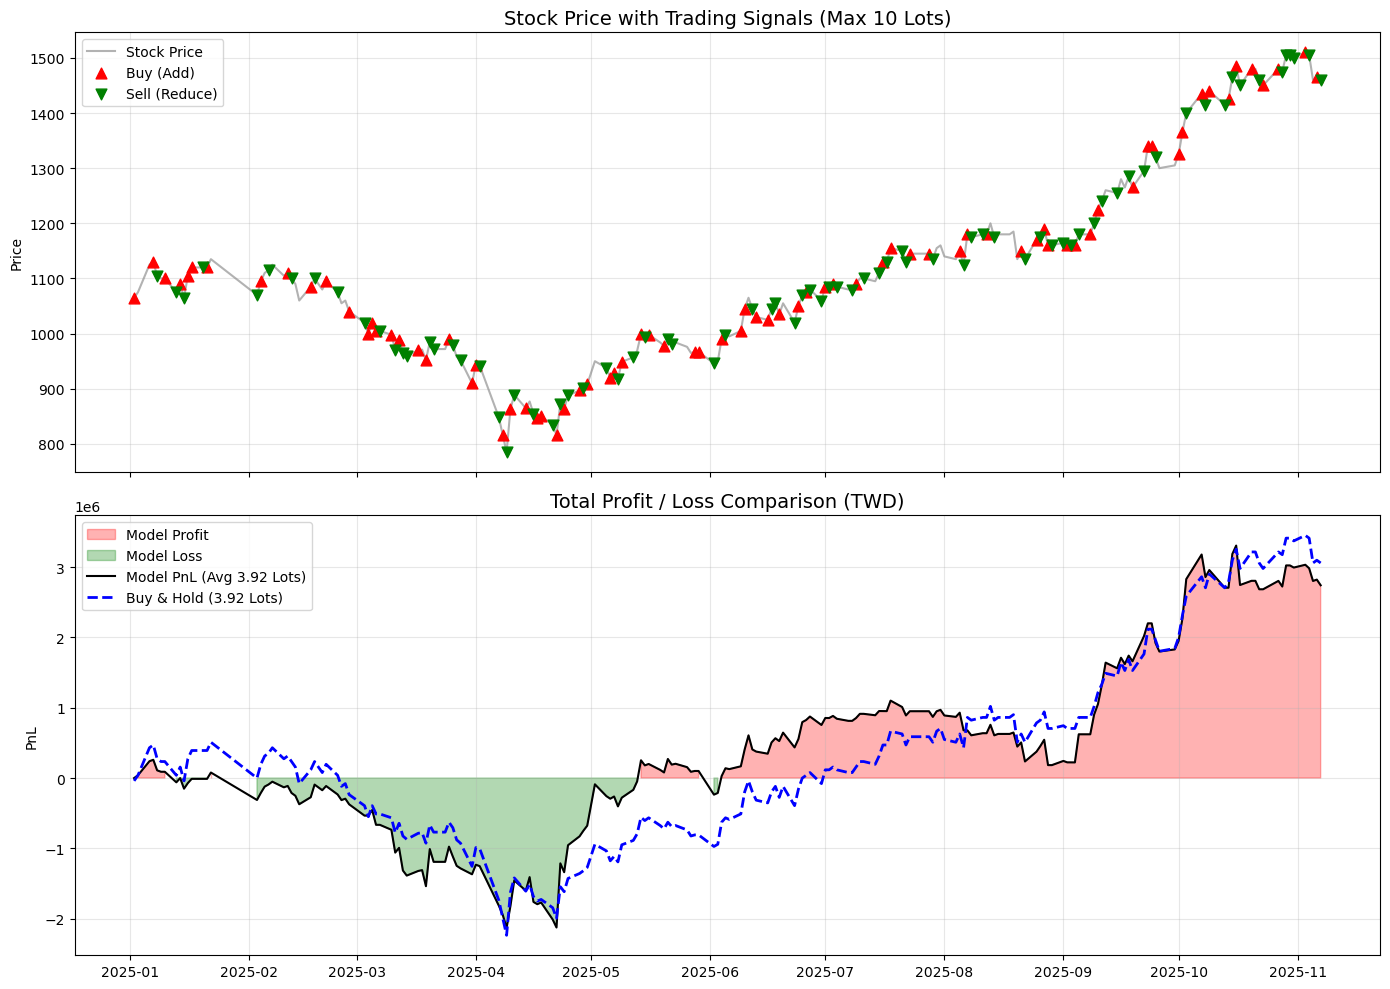

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 參數設定
# ==========================================
MAX_LOTS = 10          # 最大持倉
BH_LOTS = 3.92         # Buy & Hold 口數
CONTRACT_SIZE = 2000   # 1口 = 2000股
COST_PER_TRX = 100     # 交易成本

def load_data(price_file, pred_file):
    df_price = pd.read_csv(price_file)
    df_price['Date'] = pd.to_datetime(df_price['Date'])
    df_price.set_index('Date', inplace=True)
    df_pred = pd.read_csv(pred_file)
    df_pred['Date'] = pd.to_datetime(df_pred['Date'])
    df_pred.set_index('Date', inplace=True)
    
    df = df_price[['Open', 'Close']].join(df_pred, how='inner')
    df.sort_index(inplace=True)
    return df

def run_strategy(df):
    current_lots = 0
    avg_cost = 0
    realized_pnl = 0
    
    record_lots = []
    record_total_pnl = []
    # 新增：紀錄買賣動作 (1=買, -1=賣, 0=不動)
    trade_signals = [] 
    
    probs = df['Probability'].shift(0).fillna(0.5)
    opens = df['Open'].values
    closes = df['Close'].values
    
    for i in range(len(df)):
        price = closes[i]
        prob = probs.iloc[i]
        
        # --- [關鍵修改] 線性比例計算 ---
        # 直接將機率 (0.0~1.0) 映射到 口數 (0~MAX_LOTS)
        # 例如: 機率 0.4 -> 4口; 機率 0.9 -> 9口
        target = int(round(prob * MAX_LOTS))
        
        # 邊界檢查 (選配，防止機率異常)
        target = max(0, min(target, MAX_LOTS))
            
        # --- 執行買賣 ---
        diff = target - current_lots
        
        # 紀錄訊號
        if diff > 0:
            trade_signals.append(1)  # 買
        elif diff < 0:
            trade_signals.append(-1) # 賣
        else:
            trade_signals.append(0)  # 不動
            
        # 執行交易與損益計算
        if diff > 0:
            new_cost = (current_lots * avg_cost + diff * price) / (current_lots + diff)
            avg_cost = new_cost
            current_lots += diff
            realized_pnl -= (diff * COST_PER_TRX)
        elif diff < 0:
            sell_lots = abs(diff)
            profit = (price - avg_cost) * sell_lots * CONTRACT_SIZE
            realized_pnl += profit
            current_lots -= sell_lots
            realized_pnl -= (sell_lots * COST_PER_TRX)
            if current_lots == 0: avg_cost = 0
                
        unrealized_pnl = (closes[i] - avg_cost) * current_lots * CONTRACT_SIZE
        total_pnl = realized_pnl + unrealized_pnl
        
        record_lots.append(current_lots)
        record_total_pnl.append(total_pnl)

    df['Lots'] = record_lots
    df['Total_PnL'] = record_total_pnl
    df['Signal'] = trade_signals  # 存入 DataFrame
    
    # Buy & Hold
    bh_entry = df['Open'].iloc[0]
    bh_cost = BH_LOTS * COST_PER_TRX
    df['BH_PnL'] = (df['Close'] - bh_entry) * BH_LOTS * CONTRACT_SIZE - bh_cost
    
    return df

def plot_with_signals(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # --- 圖一：股價 + 買賣訊號 ---
    ax1.plot(df.index, df['Close'], color='gray', alpha=0.6, linewidth=1.5, label='Stock Price')
    
    # 篩選買點與賣點
    buy_points = df[df['Signal'] == 1]
    sell_points = df[df['Signal'] == -1]
    
    # 畫出訊號
    # 買進：紅色向上箭頭
    ax1.scatter(buy_points.index, buy_points['Close'], marker='^', color='red', s=60, label='Buy (Add)', zorder=5)
    # 賣出：綠色向下箭頭
    ax1.scatter(sell_points.index, sell_points['Close'], marker='v', color='green', s=60, label='Sell (Reduce)', zorder=5)
    
    ax1.set_title(f'Stock Price with Trading Signals (Max {df['Lots'].max()} Lots)', fontsize=14)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # --- 圖二：績效比較 ---
    pnl = df['Total_PnL']
    bh_pnl = df['BH_PnL']
    avg_lots = df['Lots'].mean()
    
    ax2.fill_between(df.index, pnl, 0, where=(pnl>=0), color='red', alpha=0.3, label='Model Profit')
    ax2.fill_between(df.index, pnl, 0, where=(pnl<0), color='green', alpha=0.3, label='Model Loss')
    ax2.plot(df.index, pnl, color='black', linewidth=1.5, label=f'Model PnL (Avg {avg_lots:.2f} Lots)')
    ax2.plot(df.index, bh_pnl, color='blue', linewidth=2, linestyle='--', label=f'Buy & Hold ({BH_LOTS} Lots)')
    
    ax2.set_title('Total Profit / Loss Comparison (TWD)', fontsize=14)
    ax2.set_ylabel('PnL')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('strategy_signals_plot.png')
    plt.show()

if __name__ == "__main__":
    try:
        print("Loading data...")
        df = load_data('data/2330.csv', 'stacking_pred_prob.csv')
        
        print("Running Strategy...")
        df = run_strategy(df)
        
        # 顯示最終結果
        final_pnl = df['Total_PnL'].iloc[-1]
        final_bh_pnl = df['BH_PnL'].iloc[-1]
        
        # --- 計算平均持倉口數 ---
        avg_lots = df['Lots'].mean()
        
        print("="*40)
        print(f"【績效對決】")
        print(f"AI 策略總獲利   : ${final_pnl:,.0f} (最大持倉 {df['Lots'].max()} 口)")
        print(f"Buy & Hold 總獲利: ${final_bh_pnl:,.0f} (固定持倉 {BH_LOTS} 口)")
        print(f"AI 策略平均持倉 : {avg_lots:.2f} 口")
        
        diff = final_pnl - final_bh_pnl
        if diff > 0:
            print(f"結果: AI 策略領先 ${diff:,.0f} 🏆")
        else:
            print(f"結果: Buy & Hold 領先 ${abs(diff):,.0f}")
        print("="*40)
        
        plot_with_signals(df)
        
    except FileNotFoundError:
        print("Error: Files not found.")

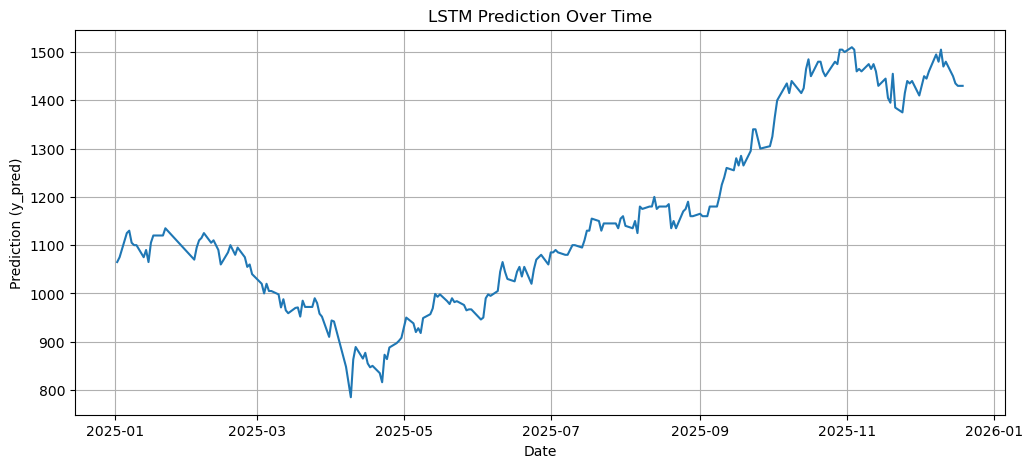

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv("data/df.csv")
df = df[df['Date'] > '2024-12-31']
# 將 Date 轉為 datetime
df['Date'] = pd.to_datetime(df['Date'])

price = df["Close"]

# 畫圖
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], price)
plt.xlabel("Date")
plt.ylabel("Prediction (y_pred)")
plt.title("LSTM Prediction Over Time")
plt.grid(True)
plt.savefig("123")
plt.show()
